In [1]:
# notebooks/era5_baseline_pipeline.ipynb
# Runs end-to-end baseline pipeline for ERA5 precipitation prediction

# LOAD LIBRARIES

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))

from src.train import train_baseline_models, print_results
from src.evaluate import evaluate_predictions, evaluate_extreme_events
from src.baseline_models import create_history_windows
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# SET UP DATA PATH & PARAMETERS

In [3]:
processed_folder = "../data"
data_path = f"{processed_folder}/era5_processed.npz"
print(data_path)

T = 7          # NUMBER OF DAYS USED AS HISTORY
horizon = 3    # SINGLE-STEP DAILY PRECIPITATION PREDICTION
p_window = 7   # NUMBER OF PERSISTANCE MODEL AVERAGE 

../data/era5_processed.npz


# TRAIN BASELINE MODELS

In [4]:
results = train_baseline_models(data_path, T=T, horizon=horizon, p_window=p_window)
print_results(results)

Baseline Results:
climatology: RMSE = 7.926787376403809, MAE = 4.746901512145996
persistence: RMSE = 8.434200286865234, MAE = 5.217033386230469
linear_regression: RMSE = 7.872400283813477, MAE = 4.753587245941162


# EVALUATE MODEL PREDICTIONS

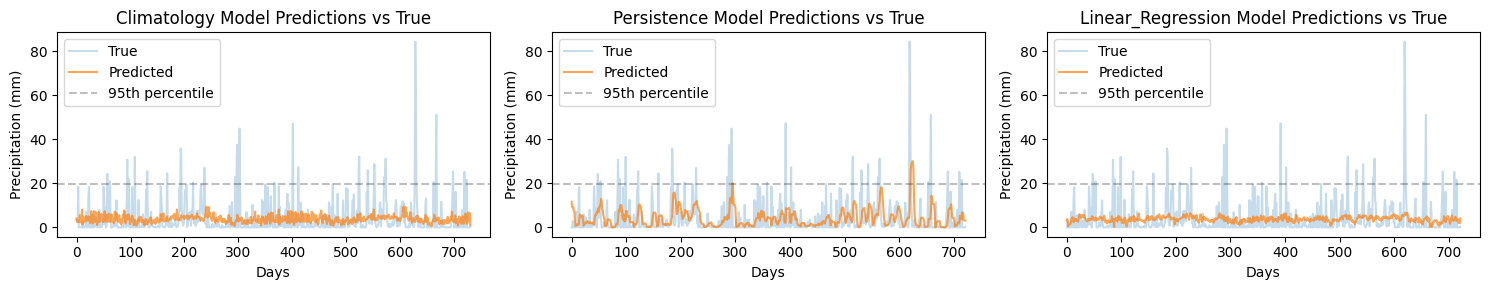

In [46]:
y_true = np.load(data_path)['y_test']
T = 7
horizon = 3

threshold = np.percentile(y_true, 95)
plt.figure(figsize=(15,3))

for i, model in enumerate(results.keys()):
    plt.subplot(1, 3, i+1)

    y_pred = results[model]['y_pred']
    
    if model in ['linear_regression', 'persistence']:
        y_true_aligned = y_true[T - 1 + horizon : T - 1 + horizon + len(y_pred)]
    else:
        y_true_aligned = y_true[:len(y_pred)]
    
    plt.plot(y_true_aligned, label='True', alpha=0.25)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.axhline(y=threshold, color='black', linestyle='--', label='95th percentile', alpha=0.25)
    
    plt.title(f"{model.title()} Model Predictions vs True")
    plt.xlabel("Days")
    plt.ylabel("Precipitation (mm)")
    plt.legend()

plt.tight_layout()
plt.show()

# EVALUATE EXTREME EVENTS (>95TH PERCENTILE)

In [45]:
for model_name, result in results.items():
    y_pred = result['y_pred']
    print(f"\nEvaluating extreme events for {model_name.title()} model:")
    evaluate_extreme_events(y_true, y_pred, percentile=95)


Evaluating extreme events for Climatology model:
Extreme events > 95th percentile -> RMSE: 29.179746627807617, MAE: 26.217456817626953
Total extreme events: 37, Total extreme events predicted: 0

Evaluating extreme events for Persistence model:
Extreme events > 95th percentile -> RMSE: 29.015710830688477, MAE: 25.428022384643555
Total extreme events: 37, Total extreme events predicted: 0

Evaluating extreme events for Linear_Regression model:
Extreme events > 95th percentile -> RMSE: 29.759979248046875, MAE: 26.608657836914062
Total extreme events: 37, Total extreme events predicted: 0


---

- *Linear Regression outperforms climatology and persistance model could indicate linear regression is capturing some of the features in the data*
- *Persistance model is a 7 day average and is the worst performer*
- *All three baseline models fail to predict any of the extreme precipitation events which indicates all models severly underestimate days with large amounts of precipitation* 

# MULTIPLE HORIZON EVALUATION

In [55]:
T = 7
horizons = [1, 2, 3, 4, 5, 6, 7]
results_horizon = {}

for h in horizons:
    print(f"\nEvaluation for horizon t+{h}\n")
    results = train_baseline_models(data_path, T=T, horizon=h)
    print_results(results)
    print("--------------------------------")

    horizon_metrics = {}
    for model_name, result in results.items():
        rmse = result['rmse']
        mae = result['mae']
        horizon_metrics[model_name] = {"rmse":rmse, "mae":mae}
    results_horizon[h] = horizon_metrics


Evaluation for horizon t+1

Baseline Results:
climatology: RMSE = 7.926787376403809, MAE = 4.746901512145996
persistence: RMSE = 8.42258071899414, MAE = 5.2026214599609375
linear_regression: RMSE = 6.750957489013672, MAE = 4.196705341339111
--------------------------------

Evaluation for horizon t+2

Baseline Results:
climatology: RMSE = 7.926787376403809, MAE = 4.746901512145996
persistence: RMSE = 8.428132057189941, MAE = 5.209817409515381
linear_regression: RMSE = 7.684643745422363, MAE = 4.642805576324463
--------------------------------

Evaluation for horizon t+3

Baseline Results:
climatology: RMSE = 7.926787376403809, MAE = 4.746901512145996
persistence: RMSE = 8.434200286865234, MAE = 5.217033386230469
linear_regression: RMSE = 7.872400283813477, MAE = 4.753587245941162
--------------------------------

Evaluation for horizon t+4

Baseline Results:
climatology: RMSE = 7.926787376403809, MAE = 4.746901512145996
persistence: RMSE = 8.44062614440918, MAE = 5.224268913269043
lin

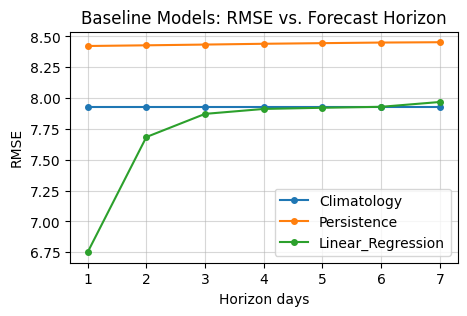

In [58]:
plt.figure(figsize=(5,3))
for model_name in results_horizon[1].keys():
    rmse_scores = [results_horizon[h][model_name]['rmse'] for h in horizons]
    plt.plot(horizons, rmse_scores, marker='o', label=model_name.title(), markersize=4)

plt.xlabel("Horizon days")
plt.ylabel("RMSE")
plt.title("Baseline Models: RMSE vs. Forecast Horizon")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()